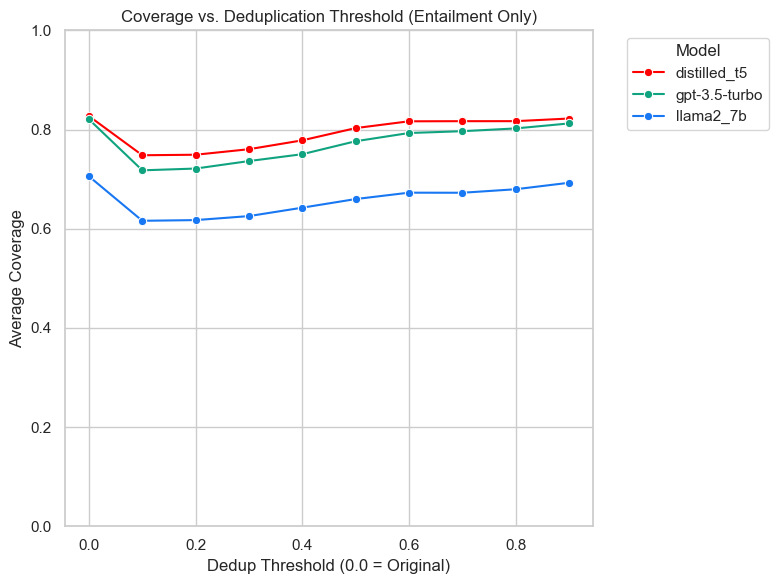

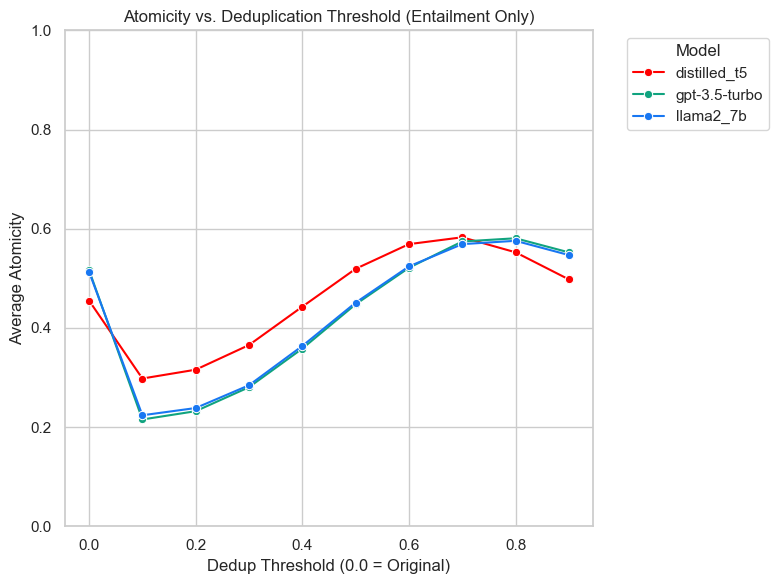


=== Average Coverage & Atomicity per Model & Dedup Threshold (Entailment Only) ===
 dedup_thr_float claim_gen_key  coverage  atomicity
             0.0  distilled_t5  0.827131   0.455089
             0.0 gpt-3.5-turbo  0.820560   0.516392
             0.0     llama2_7b  0.705581   0.513132
             0.1  distilled_t5  0.748222   0.297938
             0.1 gpt-3.5-turbo  0.717822   0.215316
             0.1     llama2_7b  0.616036   0.223824
             0.2  distilled_t5  0.749267   0.315735
             0.2 gpt-3.5-turbo  0.721385   0.232075
             0.2     llama2_7b  0.617441   0.238424
             0.3  distilled_t5  0.760413   0.365474
             0.3 gpt-3.5-turbo  0.736506   0.280425
             0.3     llama2_7b  0.625516   0.284319
             0.4 gpt-3.5-turbo  0.750362   0.358283
             0.4     llama2_7b  0.642483   0.363572
             0.4  distilled_t5  0.778292   0.442828
             0.5  distilled_t5  0.802964   0.519175
             0.5 gpt-3.5-turbo  

In [14]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# ------------------------------------------------------------------------------
# 1. Load and Flatten the JSON
# ------------------------------------------------------------------------------
RESULTS_JSON_PATH = "all_experiments_results.json"

with open(RESULTS_JSON_PATH, "r", encoding="utf-8") as f:
    grand_results = json.load(f)

rows = []
for config in grand_results:
    # Basic fields from config
    method = config["method"]             # e.g. "entailment"
    align_threshold = config["align_threshold"]
    claim_gen_key = config["claim_gen_key"]  # e.g. "distilled_t5", "gpt-3.5-turbo", ...
    dedup_threshold = config["dedup_threshold"]  # float or None
    dataset_name = config["dataset_name"]
    records = config["records"]           # list of {"record_id", "coverage", "atomicity"}

    for r in records:
        rows.append({
            "method": method,
            "align_threshold": align_threshold,
            "claim_gen_key": claim_gen_key,
            "dedup_threshold": dedup_threshold,
            "dataset_name": dataset_name,
            "record_id": r["record_id"],
            "coverage": r["coverage"],
            "atomicity": r["atomicity"]
        })

df = pd.DataFrame(rows)

# ------------------------------------------------------------------------------
# 2. Filter to: method="entailment", dedup_threshold in [None, 0.5, 0.7, 0.9]
#    and then average coverage & atomicity PER model.
# ------------------------------------------------------------------------------
TARGET_METHOD = "entailment"
TARGET_DEDUP_THRESHOLDS = [None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

df_filtered = df[
    (df["method"] == TARGET_METHOD) &
    (df["dedup_threshold"].isin(TARGET_DEDUP_THRESHOLDS))
].copy()

# We'll replace None with 0.0 so we can treat the threshold as numeric
# for a nice line chart on x-axis
df_filtered["dedup_thr_float"] = df_filtered["dedup_threshold"].fillna(0.0)

# ------------------------------------------------------------------------------
# 3. Group by (dedup_thr_float, claim_gen_key) and average coverage/atomicity
#    across all records, align_thresholds, etc.
# ------------------------------------------------------------------------------
grouped = df_filtered.groupby(
    ["dedup_thr_float", "claim_gen_key"], as_index=False
).agg({
    "coverage": "mean",
    "atomicity": "mean"
})

# OPTIONAL: Sort so the x-axis (dedup_thr_float) is in ascending order
grouped = grouped.sort_values("dedup_thr_float")

# ------------------------------------------------------------------------------
# 4. Define our custom palette by model
# ------------------------------------------------------------------------------
custom_palette = {
    "gpt-3.5-turbo": "#10A37F",  # Pale/brand green for OpenAI
    "llama2_7b":     "#1877F2",  # Blue for Meta
    "distilled_t5":  "#FF0000"   # Red
}

# ------------------------------------------------------------------------------
# 5. Line Chart: Coverage vs. Dedup Threshold
# ------------------------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.lineplot(
    data=grouped,
    x="dedup_thr_float", 
    y="coverage",
    hue="claim_gen_key",
    marker="o",
    palette=custom_palette  # <--- Use our custom palette
)
plt.title("Coverage vs. Deduplication Threshold (Entailment Only)")
plt.xlabel("Dedup Threshold (0.0 = Original)")
plt.ylabel("Average Coverage")
plt.ylim(0, 1)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 6. Line Chart: Atomicity vs. Dedup Threshold
# ------------------------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.lineplot(
    data=grouped,
    x="dedup_thr_float",
    y="atomicity",
    hue="claim_gen_key",
    marker="o",
    palette=custom_palette  # <--- Use our custom palette here as well
)
plt.title("Atomicity vs. Deduplication Threshold (Entailment Only)")
plt.xlabel("Dedup Threshold (0.0 = Original)")
plt.ylabel("Average Atomicity")
plt.ylim(0, 1)  # or adjust if needed
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 7. (Optional) Print a Small Table for Quick Reference
# ------------------------------------------------------------------------------
print("\n=== Average Coverage & Atomicity per Model & Dedup Threshold (Entailment Only) ===")
print(grouped.to_string(index=False))

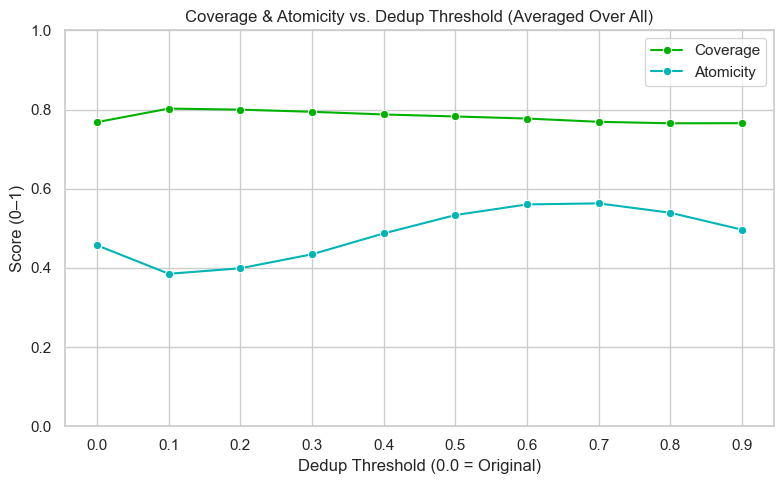

=== Coverage & Atomicity by Dedup Threshold (All Methods & Models) ===
 dedup_thr_float  coverage  atomicity  coverage_diff  atomicity_diff
             0.0  0.768396   0.456921       0.000000        0.000000
             0.1  0.802528   0.385135       0.034132       -0.071785
             0.2  0.799865   0.399136       0.031468       -0.057784
             0.3  0.794366   0.434460       0.025970       -0.022461
             0.4  0.787691   0.487103       0.019295        0.030182
             0.5  0.782604   0.533477       0.014207        0.076556
             0.6  0.777355   0.560374       0.008959        0.103454
             0.7  0.769132   0.563062       0.000736        0.106141
             0.8  0.765375   0.539396      -0.003021        0.082476
             0.9  0.765610   0.496761      -0.002787        0.039841


In [16]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")

# ------------------------------------------------------------------------------
# 1) Load and Flatten the JSON
# ------------------------------------------------------------------------------
RESULTS_JSON = "all_experiments_results.json"

with open(RESULTS_JSON, "r", encoding="utf-8") as f:
    grand_results = json.load(f)

rows = []
for config in grand_results:
    method = config["method"]
    align_threshold = config["align_threshold"]
    claim_gen_key = config["claim_gen_key"]
    dedup_threshold = config["dedup_threshold"]  # None or float
    dataset_name = config["dataset_name"]
    records = config["records"]

    for r in records:
        rows.append({
            "method": method,
            "align_threshold": align_threshold,
            "claim_gen_key": claim_gen_key,
            "dedup_threshold": dedup_threshold,
            "dataset_name": dataset_name,
            "record_id": r["record_id"],
            "coverage": r["coverage"],
            "atomicity": r["atomicity"]
        })

df = pd.DataFrame(rows)

# ------------------------------------------------------------------------------
# 2) Filter the Dedup Thresholds: [None, 0.1, 0.2, ... 0.9]
#    Then treat 'None' as 0.0 for plotting on the same numeric scale
# ------------------------------------------------------------------------------
TARGET_THRESHOLDS = [None] + [round(x, 1) for x in np.arange(0.1, 1.0, 0.1)]
df_filtered = df[df["dedup_threshold"].isin(TARGET_THRESHOLDS)].copy()
df_filtered["dedup_thr_float"] = df_filtered["dedup_threshold"].fillna(0.0)

# ------------------------------------------------------------------------------
# 3) Average coverage & atomicity over ALL alignment methods & models
# ------------------------------------------------------------------------------
df_summary = df_filtered.groupby("dedup_thr_float", as_index=False).agg({
    "coverage": "mean",
    "atomicity": "mean"
})
df_summary = df_summary.sort_values("dedup_thr_float")

# ------------------------------------------------------------------------------
# 4) Compute the baseline (dedup_thr_float=0.0) coverage & atomicity
# ------------------------------------------------------------------------------
baseline_coverage = df_summary.loc[df_summary["dedup_thr_float"] == 0.0, "coverage"].values[0]
baseline_atomicity = df_summary.loc[df_summary["dedup_thr_float"] == 0.0, "atomicity"].values[0]

# ------------------------------------------------------------------------------
# 5) Add columns for difference w.r.t. the baseline
# ------------------------------------------------------------------------------
df_summary["coverage_diff"] = df_summary["coverage"] - baseline_coverage
df_summary["atomicity_diff"] = df_summary["atomicity"] - baseline_atomicity

# ------------------------------------------------------------------------------
# 6) Single Plot Combining Coverage & Atomicity as Two Lines (Darker Colors)
# ------------------------------------------------------------------------------
plt.figure(figsize=(8,5))

# Coverage line
sns.lineplot(
    data=df_summary,
    x="dedup_thr_float",
    y="coverage",
    marker="o",
    color="#00B200",
    label="Coverage"
)

# Atomicity line
sns.lineplot(
    data=df_summary,
    x="dedup_thr_float",
    y="atomicity",
    marker="o",
    color="#00B5B5",
    label="Atomicity"
)

plt.title("Coverage & Atomicity vs. Dedup Threshold (Averaged Over All)")
plt.xlabel("Dedup Threshold (0.0 = Original)")
plt.ylabel("Score (0–1)")
plt.ylim(0, 1)
plt.xticks(df_summary["dedup_thr_float"])
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 7) (Optional) Print Table with Differences
# ------------------------------------------------------------------------------
print("=== Coverage & Atomicity by Dedup Threshold (All Methods & Models) ===")
print(df_summary.to_string(index=False))

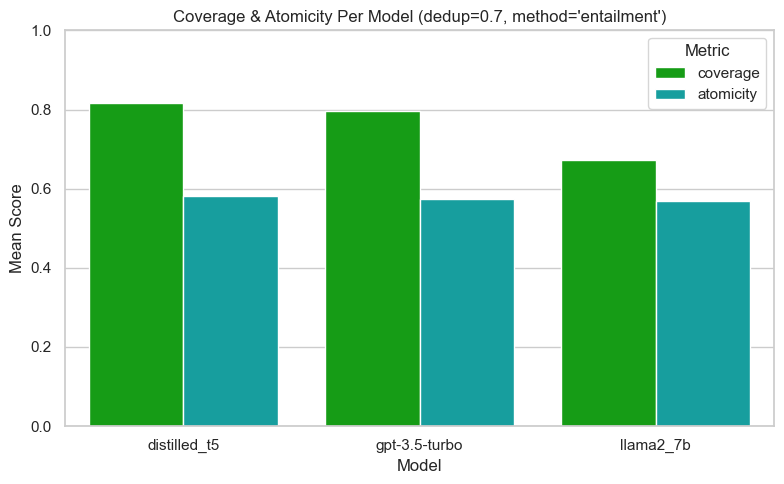

=== Mean Coverage & Atomicity per Model (dedup=0.7, entailment) ===
claim_gen_key  coverage  atomicity
 distilled_t5  0.816937   0.582772
gpt-3.5-turbo  0.796738   0.574305
    llama2_7b  0.672587   0.568973


In [18]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# ----------------------------------------------------------------------
# 1. Load & Flatten the JSON (Adjust path as needed)
# ----------------------------------------------------------------------
RESULTS_JSON = "all_experiments_results.json"

with open(RESULTS_JSON, "r", encoding="utf-8") as f:
    grand_results = json.load(f)

rows = []
for config in grand_results:
    method = config["method"]
    align_threshold = config["align_threshold"]
    claim_gen_key = config["claim_gen_key"]
    dedup_threshold = config["dedup_threshold"]
    dataset_name = config["dataset_name"]

    for record in config["records"]:
        rows.append({
            "method": method,
            "align_threshold": align_threshold,
            "claim_gen_key": claim_gen_key,
            "dedup_threshold": dedup_threshold,
            "dataset_name": dataset_name,
            "record_id": record["record_id"],
            "coverage": record["coverage"],
            "atomicity": record["atomicity"]
        })

df = pd.DataFrame(rows)

# ----------------------------------------------------------------------
# 2. Filter to method="entailment" and dedup_threshold=0.7
# ----------------------------------------------------------------------
df_filtered = df[
    (df["method"] == "entailment") &
    (df["dedup_threshold"] == 0.7)
].copy()

# ----------------------------------------------------------------------
# 3. Group by each model and average coverage/atomicity
# ----------------------------------------------------------------------
grouped = df_filtered.groupby("claim_gen_key", as_index=False).agg({
    "coverage": "mean",
    "atomicity": "mean"
})

# ----------------------------------------------------------------------
# 4. Melt coverage & atomicity so we can plot them side by side in one chart
# ----------------------------------------------------------------------
melted = grouped.melt(
    id_vars="claim_gen_key",
    value_vars=["coverage", "atomicity"],
    var_name="metric",
    value_name="score"
)

# ----------------------------------------------------------------------
# 5. Create a grouped bar chart with custom colors
# ----------------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.barplot(
    data=melted,
    x="claim_gen_key",
    y="score",
    hue="metric",
    # Map coverage -> #00B200 (green), atomicity -> #00B5B5 (teal)
    palette={
        "coverage": "#00B200",
        "atomicity": "#00B5B5"
    }
)

plt.title("Coverage & Atomicity Per Model (dedup=0.7, method='entailment')")
plt.xlabel("Model")
plt.ylabel("Mean Score")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 6. (Optional) Print the numeric table
# ----------------------------------------------------------------------
print("=== Mean Coverage & Atomicity per Model (dedup=0.7, entailment) ===")
print(grouped.to_string(index=False))
